# Taking GeoGrapher for a Spin

Let us see how we can use GeoGrapher to a build a toy example dataset of stadiums.
You can download the file `stadiums.geojson` containing the stadiums from ([link](https://github.com/dida-do/GeoGrapher/tree/main/notebooks/stadiums.geojson)).

## 1. Creating an Empty Dataset

First, we import geographer, as well as some other imports we will need.

In [ ]:
# !pip install geographer matplotlib

In [1]:
from datetime import date, timedelta
import os

import geographer as gg
import geopandas as gpd
from pathlib import Path

The GeoGrapher library is built around the `Connector` class. A connector organizes a dataset of raster and vector data keeping track of the containment and intersection relations between raster and vector features. To create an empty dataset, we use the `from_scratch` factory method:

In [2]:
from geographer import Connector

DATA_DIR = Path("gg_example_dataset_blogpost")

connector = Connector.from_scratch(
    data_dir=DATA_DIR,
    task_vector_classes=["stadium"],
)

This creates a connector with a dataset in `DATA_DIR`.

The most important attributes of a connector are its `vectors` and `rasters` attributes. The `vectors` GeoDataFrame contains the vector geometries of the stadiums as well as tabular information about the stadiums (name, country, etc). The `rasters` GeoDataFrame contains as geometries the bounding boxes of the rasters in our dataset as well as tabular information about the rasters (e.g. raster name, date, etc). Of course, both GeoDataFrames are still empty. Let us change that. 

Let's try adding our stadiums to the `vectors`. You can find the example geojson file in [https://github.com/dida-do/GeoGrapher/blob/main/notebooks/stadiums_binary.geojson](https://github.com/dida-do/GeoGrapher/blob/main/notebooks/stadiums_binary.geojson).

In [3]:
stadiums = gpd.read_file("stadiums_binary.geojson")
stadiums = stadiums.set_index("vector_name")
stadiums

,location,type,geometry
vector_name,,,
Munich Olympiastadion,"Munich, Germany",stadium,"POLYGON Z ((11.54677 48.17472 0, 11.54469 48.1..."
Munich Track and Field Stadium1,"Munich, Germany",stadium,"POLYGON Z ((11.54382 48.17279 0, 11.5438 48.17..."
Munich Olympia Track and Field2,"Munich, Germany",stadium,"POLYGON Z ((11.54686 48.17892 0, 11.54685 48.1..."
Munich Staedtisches Stadion Dantestr,"Munich, Germany",stadium,"POLYGON Z ((11.52913 48.16874 0, 11.5291 48.16..."
Vasil Levski National Stadium,"Sofia, Bulgaria",stadium,"POLYGON Z ((23.3341 42.68813 0, 23.33408 42.68..."
Bulgarian Army Stadium,"Sofia, Bulgaria",stadium,"POLYGON Z ((23.34065 42.68492 0, 23.34062 42.6..."
Arena Sofia,"Sofia, Bulgaria",stadium,"POLYGON Z ((23.34018 42.68318 0, 23.34018 42.6..."
Jingu Baseball Stadium,"Tokyo, Japan",stadium,"POLYGON Z ((139.71597 35.6749 0, 139.71599 35...."
Japan National Stadium,"Tokyo, Japan",stadium,"POLYGON Z ((139.71482 35.67644 0, 139.71484 35..."


Now, we can integrate the vector features into the dataset, i.e. into the connector:

In [4]:
connector.add_to_vectors(stadiums)

We see that the stadiums have been added to the connector:

In [5]:
connector.vectors

,geometry,raster_count,location,type
vector_name,,,,
Munich Olympiastadion,"POLYGON Z ((11.54677 48.17472 0, 11.54469 48.1...",0,"Munich, Germany",stadium
Munich Track and Field Stadium1,"POLYGON Z ((11.54382 48.17279 0, 11.5438 48.17...",0,"Munich, Germany",stadium
Munich Olympia Track and Field2,"POLYGON Z ((11.54686 48.17892 0, 11.54685 48.1...",0,"Munich, Germany",stadium
Munich Staedtisches Stadion Dantestr,"POLYGON Z ((11.52913 48.16874 0, 11.5291 48.16...",0,"Munich, Germany",stadium
Vasil Levski National Stadium,"POLYGON Z ((23.3341 42.68813 0, 23.33408 42.68...",0,"Sofia, Bulgaria",stadium
Bulgarian Army Stadium,"POLYGON Z ((23.34065 42.68492 0, 23.34062 42.6...",0,"Sofia, Bulgaria",stadium
Arena Sofia,"POLYGON Z ((23.34018 42.68318 0, 23.34018 42.6...",0,"Sofia, Bulgaria",stadium
Jingu Baseball Stadium,"POLYGON Z ((139.71597 35.6749 0, 139.71599 35....",0,"Tokyo, Japan",stadium
Japan National Stadium,"POLYGON Z ((139.71482 35.67644 0, 139.71484 35...",0,"Tokyo, Japan",stadium


# 3. Downloading Rasters for the Vector Data

To download rasters for the stadiums, we will use a downloader based on [eodag](https://eodag.readthedocs.io/en/stable/index.html). We will download rasters from the [copernicus dataspace](https://dataspace.copernicus.eu/). If you do not yet have a copernicus dataspace account, you can create one [here](https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/auth?client_id=cdse-public&redirect_uri=https%3A%2F%2Fdataspace.copernicus.eu%2Fbrowser%2F&response_type=code&scope=openid). To use eodag, eodag will need the username and password of your copernicus dataspace account. One can set these in a config file, but here we will use environment variables:

In [6]:
# os.environ["EODAG__COP_DATASPACE__AUTH__CREDENTIALS__USERNAME"] = "PLEASE_CHANGE_ME"
# os.environ["EODAG__COP_DATASPACE__AUTH__CREDENTIALS__PASSWORD"] = "PLEASE_CHANGE_ME"

In [7]:
from geographer.downloaders import (
    RasterDownloaderForVectors,
    EodagDownloaderForSingleVector,
    Sentinel2SAFEProcessor,
)

downloader_for_single_vector = EodagDownloaderForSingleVector()
download_processor = Sentinel2SAFEProcessor()

downloader = RasterDownloaderForVectors(
    downloader_for_single_vector=downloader_for_single_vector,
    download_processor=download_processor,
)

To download rasters and add them to our dataset we then run the following command. Downloading the large SAFE files and processing the SAFEs to GeoTiffs can take quite a while.

In [8]:
# Here, we define the parameters needed by the EodagDownloaderForSingleVector.download method
downloader_params = {
    "search_kwargs": {  # Keyword arguments for the eodag search_all method
        "provider": "cop_dataspace",  # Download from copernicus dataspace 
        "productType": "S2_MSI_L2A",  # Search for Sentinel-2 L2A products
        "start": (date.today() - timedelta(days=364)).strftime("%Y-%m-%d"),  # one year ago
        "end": date.today().strftime("%Y-%m-%d"),  # today
    },
    "filter_online": True,  # Filter out products that are not online
    "sort_by": ("cloudCover", "ASC"),  # Sort products by percentage of cloud cover in ascending order
    "suffix_to_remove": ".SAFE"  # Will strip .SAFE from the stem of the tif file names
}
# Here, we define the parameters needed by the Sentinel2SAFEProcessor
processor_params = {
    "resolution": 10,  # Extract all 10m resolution bands
    "delete_safe": True,  # Delete the SAFE file after extracting a .tif file
}    

downloader.download(
    connector=connector,
    downloader_params=downloader_params,
    processor_params=processor_params,
)

0it [00:00, ?it/s]

0.00B [00:00, ?B/s]

Extracting tif from S2A_MSIL2A_20241108T092201_N0511_R093_T34TFN_20241108T123352.SAFE.:   0%|          | 0/21 …

2024-11-21 22:56:22,769 - geographer.downloaders.sentinel2_safe_unpacking - INFO - Using all zero band for gml mask ('CLOUDS', 'B00') for S2A_MSIL2A_20241108T092201_N0511_R093_T34TFN_20241108T123352.SAFE


0.00B [00:00, ?B/s]

Extracting tif from S2B_MSIL2A_20240731T100559_N0511_R022_T32UPU_20240731T125141.SAFE.:   0%|          | 0/21 …

2024-11-21 23:01:13,644 - geographer.downloaders.sentinel2_safe_unpacking - INFO - Using all zero band for gml mask ('CLOUDS', 'B00') for S2B_MSIL2A_20240731T100559_N0511_R022_T32UPU_20240731T125141.SAFE


0.00B [00:00, ?B/s]

Extracting tif from S2B_MSIL2A_20231208T013039_N0509_R074_T54SUE_20231208T031743.SAFE.:   0%|          | 0/21 …

2024-11-21 23:06:47,516 - geographer.downloaders.sentinel2_safe_unpacking - INFO - Using all zero band for gml mask ('CLOUDS', 'B00') for S2B_MSIL2A_20231208T013039_N0509_R074_T54SUE_20231208T031743.SAFE


 The `rasters` attribute now contains information about the rasters:

In [9]:
connector.rasters

,geometry,raster_processed?,orig_crs_epsg_code
raster_name,,,
S2A_MSIL2A_20241108T092201_N0511_R093_T34TFN_20241108T123352.tif,"POLYGON ((23.54663 42.33578, 23.58754 43.32358...",True,32634
S2B_MSIL2A_20240731T100559_N0511_R022_T32UPU_20240731T125141.tif,"POLYGON ((11.79809 47.73104, 11.85244 48.71769...",True,32632
S2B_MSIL2A_20231208T013039_N0509_R074_T54SUE_20231208T031743.tif,"POLYGON ((140.00972 35.15084, 139.99743 36.140...",True,32654


The connector keeps track of the containment and intersection relations between vector features and rasters in the form of an internal bipartite graph. We can ask questions about this graph, such as which rasters contain (or intersect) a given vector feature (stadium):

In [10]:
# rasters containing a vector feature
vector_name = "Munich Olympiastadion"
containing_rasters = connector.rasters_containing_vector(vector_name)
print(f"rasters containing {vector_name}:\n{containing_rasters} \n")

# vector features intersecting a raster
raster_name = containing_rasters[0]
intersecting_vectors = connector.vectors_intersecting_raster(raster_name)
print(f"vector features (stadiums) intersecting {raster_name}:\n{intersecting_vectors}")

rasters containing Munich Olympiastadion:
['S2B_MSIL2A_20240731T100559_N0511_R022_T32UPU_20240731T125141.tif'] 

vector features (stadiums) intersecting S2B_MSIL2A_20240731T100559_N0511_R022_T32UPU_20240731T125141.tif:
['Munich Olympiastadion', 'Munich Staedtisches Stadion Dantestr', 'Munich Track and Field Stadium1', 'Munich Olympia Track and Field2']


We can now create a dataset of cutouts around each stadium.

In [11]:
from geographer.cutters import get_cutter_rasters_around_every_vector

IMG_SIZE = 512
TARGET_DATA_DIR = Path(f"gg_example_dataset_blogpost_cutouts{IMG_SIZE}")

cutter = get_cutter_rasters_around_every_vector(
    source_data_dir=DATA_DIR,
    target_data_dir=TARGET_DATA_DIR,
    name="example_cutter",  # for saving
    new_raster_size=IMG_SIZE,  # in pixels
    bands={"rasters": [1, 2, 3]},  # we only want the RGB (or BGR for Sentinel-2) bands
)
target_connector = cutter.cut()

Cutting dataset:   0%|          | 0/9 [00:00<?, ?it/s]

And finally, we can create segmentation labels (masks) for our new dataset:

In [12]:
from geographer.label_makers import SegLabelMakerCategorical

label_maker = SegLabelMakerCategorical()
label_maker.make_labels(connector=target_connector)

Making labels:   0%|          | 0/3 [00:00<?, ?it/s]

We can now take a look at one of our rasters and the segmentation label/mask:

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

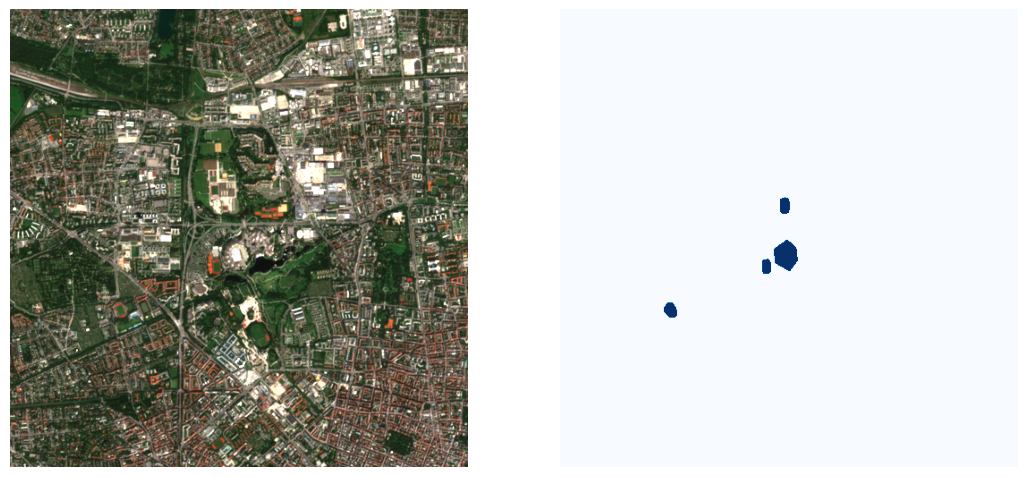

In [13]:
import rioxarray
from matplotlib import pyplot as plt

raster_paths = target_connector.rasters_containing_vector(
    "Munich Olympiastadion", mode="paths"
)
raster_path = raster_paths[0]
label_path = target_connector.labels_dir / raster_path.name

raster = (
    rioxarray.open_rasterio(raster_path).sel(band=[1, 2, 3]).values.transpose(1, 2, 0)
    / 65535
)
label = rioxarray.open_rasterio(label_path).values.transpose(1, 2, 0) / 255

fig, ax = plt.subplots(1, 2, figsize=(13, 13))

ax[0].imshow(raster)
ax[0].axis("off")

ax[1].imshow(label, cmap="Blues")
ax[1].axis("off")